### 한글 폰트 설정하기

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and direc

In [1]:
# 런타임 재시작 후 아래 코드를 실행합니다.

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

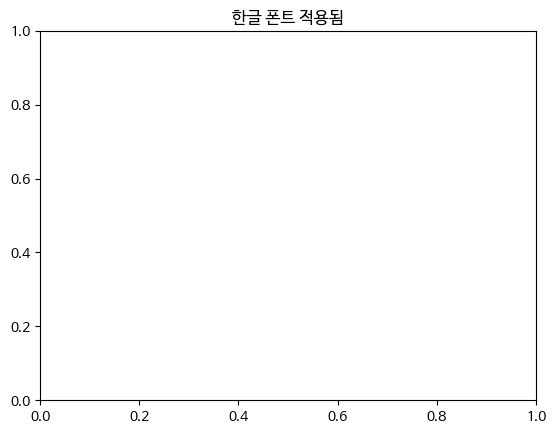

In [2]:
plt.title('한글 폰트 적용됨')
plt.show()

위 한글 폰트 적용됨 문구가 잘 나오면 정상 동작

# 데이터 불러오기

In [3]:
!gdown 1WddbLtcEA3IBnjTaoaohUVpcOOUALeU5
!unzip helmet.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: images/hard_hat_workers0.png  
  inflating: images/hard_hat_workers1.png  
  inflating: images/hard_hat_workers10.png  
  inflating: images/hard_hat_workers100.png  
  inflating: images/hard_hat_workers1000.png  
  inflating: images/hard_hat_workers1001.png  
  inflating: images/hard_hat_workers1002.png  
  inflating: images/hard_hat_workers1003.png  
  inflating: images/hard_hat_workers1004.png  
  inflating: images/hard_hat_workers1005.png  
  inflating: images/hard_hat_workers1006.png  
  inflating: images/hard_hat_workers1007.png  
  inflating: images/hard_hat_workers1008.png  
  inflating: images/hard_hat_workers1009.png  
  inflating: images/hard_hat_workers101.png  
  inflating: images/hard_hat_workers1010.png  
  inflating: images/hard_hat_workers1011.png  
  inflating: images/hard_hat_workers1012.png  
  inflating: images/hard_hat_workers1013.png  
  inflating: images/hard_hat_workers1014.png  
  inflating: images/hard_hat_worke

In [4]:
!ls

annotations  helmet.zip  images  sample_data


In [5]:
import os

PATH = '.'
IMG_DIR = PATH + "/images"
XML_DIR = PATH + "/annotations"

xml_files = [os.path.join(XML_DIR, x) for x in os.listdir(XML_DIR) if x.endswith(".xml")]

In [6]:
xml_files[0]

'./annotations/hard_hat_workers3728.xml'

In [7]:
!cat ./annotations/hard_hat_workers2330.xml


<annotation>
    <folder>images</folder>
    <filename>hard_hat_workers2330.png</filename>
    <size>
        <width>416</width>
        <height>415</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>119</xmin>
            <ymin>192</ymin>
            <xmax>155</xmax>
            <ymax>241</ymax>
        </bndbox>
    </object>
    <object>
        <name>helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>215</xmin>
            <ymin>162</ymin>
            <xmax>254</xmax>
            <ymax>207</ymax>
        </bndbox>
    </object>
</annotation>

In [8]:
import xml.etree.ElementTree as ET

#xml 파일에서 이미지 위치를 가져오기
def extract_info_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    labels = []
    filename = root.find('filename').text
    for boxes in root.iter('object'):
        label = boxes.find('name').text
        if label == "head" or label == "person":
          return filename, 0

    return filename, 1

In [9]:
import cv2
import numpy as np

# 이미지 특징 추출하기
img_data = []
label_data = []

for xml_file in xml_files:
    # XML 파일 파싱하기
    filename, label = extract_info_from_xml(xml_file)

    # 이미지 파일 읽기
    img_file = os.path.join(IMG_DIR, filename)
    img = cv2.imread(img_file)
    label_data.append(label)
    resized_img = cv2.resize(img, (224, 224))
    img_data.append(resized_img)

img_data = np.array(img_data)
label_data = np.array(label_data)

In [10]:
len(img_data), len(label_data)

(5000, 5000)

In [11]:
from collections import Counter

label_counter = Counter(label_data)
label_counter

Counter({0: 1060, 1: 3940})

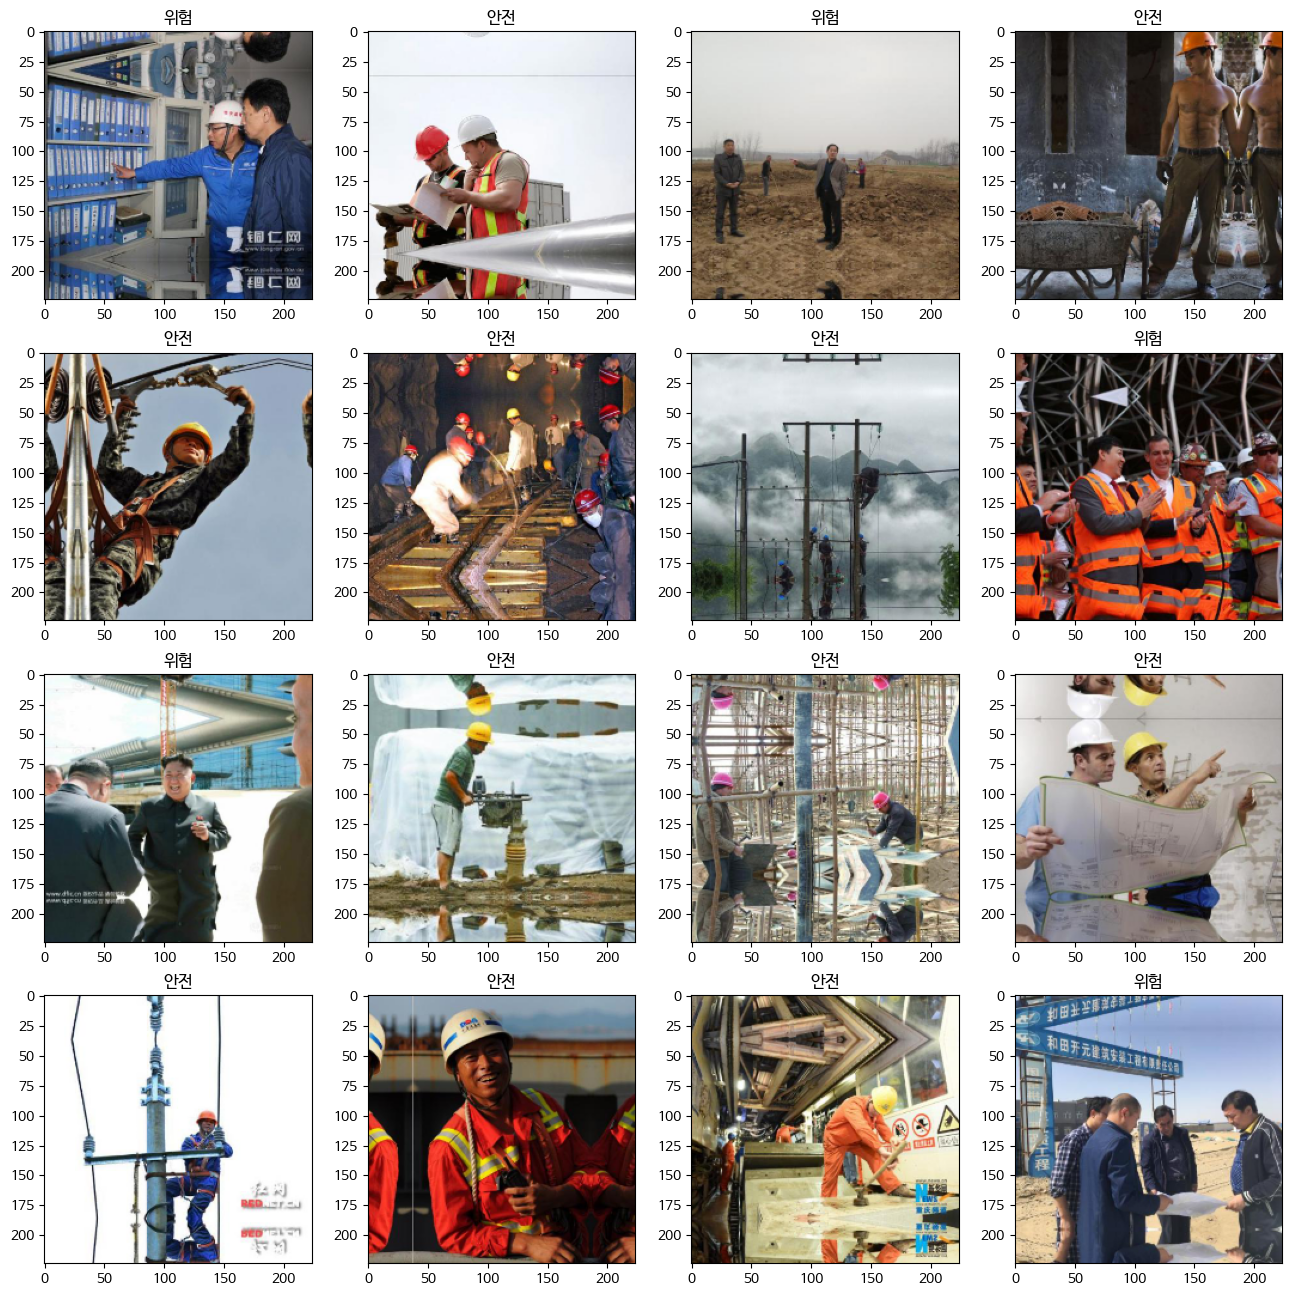

In [12]:
labels_to_names = {0: '위험', 1: '안전'}
plt.figure(figsize=(16,16))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(cv2.cvtColor(img_data[i], cv2.COLOR_BGR2RGB))
  label_name = labels_to_names[label_data[i]]
  plt.title(label_name)
plt.show()

# 모델 설계

In [13]:
from sklearn.model_selection import train_test_split

# 데이터 나누기

x_train, x_test, y_train, y_test = train_test_split(img_data, label_data, test_size=0.1, stratify=label_data, random_state=42)

In [14]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

In [16]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 222, 222, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 220, 220, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                        

In [17]:
from tensorflow.keras.metrics import Recall, Precision, AUC

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy',
                      Recall(name='recall'),
                      Precision(name='precision'),
                      AUC(name='auc')])

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode='max', verbose=1)

In [19]:
# 모델 학습
base_history = model.fit(x_train, y_train, batch_size=32, validation_split=0.2, epochs=20,
                         callbacks=[model_checkpoint])

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 6.1367 - accuracy: 0.6917 - recall: 0.7987 - precision: 0.8078 - auc: 0.5603
Epoch 1: val_auc improved from -inf to 0.49718, saving model to best_model.keras
113/113 [==============================] - 35s 185ms/step - loss: 6.1367 - accuracy: 0.6917 - recall: 0.7987 - precision: 0.8078 - auc: 0.5603 - val_loss: 9.3475 - val_accuracy: 0.7844 - val_recall: 0.9958 - val_precision: 0.7871 - val_auc: 0.4972
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 2.0106 - accuracy: 0.7050 - recall: 0.8375 - precision: 0.7981 - auc: 0.5873
Epoch 2: val_auc improved from 0.49718 to 0.50000, saving model to best_model.keras
113/113 [==============================] - 17s 149ms/step - loss: 2.0106 - accuracy: 0.7050 - recall: 0.8375 - precision: 0.7981 - auc: 0.5873 - val_loss: 7.8422 - val_accuracy: 0.7878 - val_recall: 1.0000 - val_precision: 0.7878 - val_auc: 0.5000
Epoch 3/20
113/113 [=========================

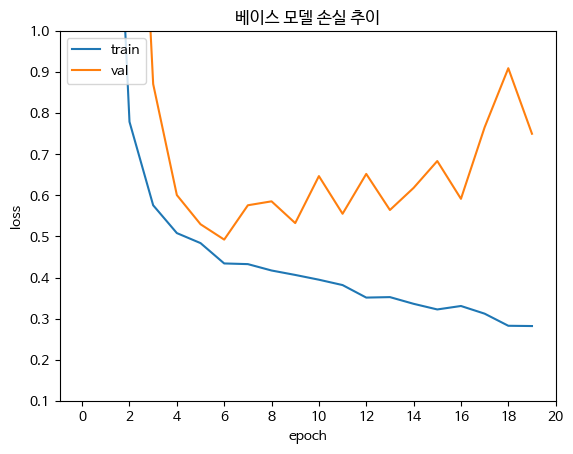

In [20]:
# base_history 시각화

plt.plot(base_history.history['loss'])
plt.plot(base_history.history['val_loss'])
plt.title('베이스 모델 손실 추이')
plt.xticks(range(0, 21, 2)) # x축 눈금 지정
plt.ylim([0.1, 1.0]) # y축 범위 지정
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
model = load_model('best_model.keras')

# 불러온 모델로부터 테스트 데이터에 대한 확률값을 예측합니다.
predicted_probabilities = model.predict(x_test)

# 확률값을 0 또는 1로 바꿀 임계값을 정의합니다.
threshold = 0.5

# 확률값을 예측 라벨(0 또는 1)로 바꿉니다.
y_pred = (predicted_probabilities > threshold).astype(int)

16/16 [==============================] - 2s 108ms/step


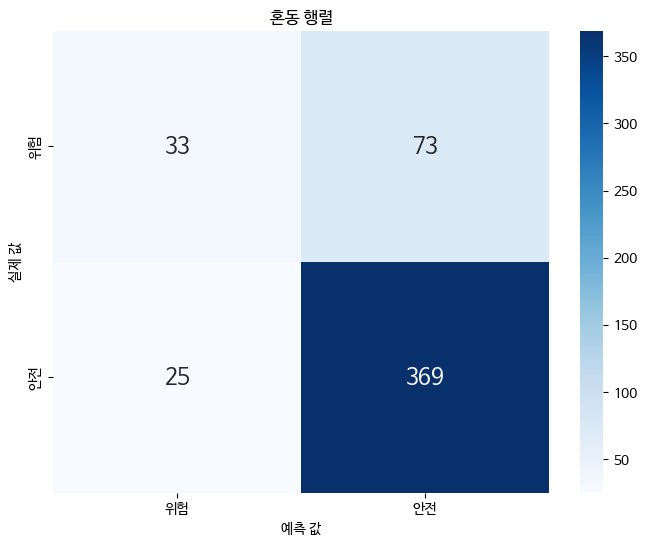

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 혼동 행렬을 계산합니다.
cm = confusion_matrix(y_test, y_pred)

# seaborn의 heatmap을 사용하여 혼동 행렬을 시각화합니다.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
            xticklabels=['위험', '안전'], yticklabels=['위험', '안전'])
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.title('혼동 행렬')
plt.show()

# 전이학습 (EfficientNet 모델 사용)

In [23]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

feature_extractor = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

82420632/82420632 [==============================] - 2s 0us/step


In [24]:
feature_extractor.trainable = False

In [25]:
img_data = preprocess_input(img_data)

In [26]:
from sklearn.model_selection import train_test_split

# 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(img_data, label_data, test_size=0.1, stratify=label_data, random_state=42)

In [27]:
model = Sequential()
model.add(feature_extractor)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 20332641 (77.56 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


In [29]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0005),
             loss='binary_crossentropy',
             metrics=['accuracy',
                      Recall(name='recall'),
                      Precision(name='precision'),
                      AUC(name='auc')])

model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode='max', verbose=1)

transfer_learning_history = model.fit(x_train, y_train, batch_size=32, validation_split=0.2, epochs=20,
                         callbacks=[model_checkpoint])

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.7683 - recall: 0.9309 - precision: 0.8054 - auc: 0.6482
Epoch 1: val_auc improved from -inf to 0.75907, saving model to best_model.keras
113/113 [==============================] - 26s 112ms/step - loss: 0.5115 - accuracy: 0.7683 - recall: 0.9309 - precision: 0.8054 - auc: 0.6482 - val_loss: 0.4455 - val_accuracy: 0.8133 - val_recall: 0.9619 - val_precision: 0.8287 - val_auc: 0.7591
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.4275 - accuracy: 0.8289 - recall: 0.9648 - precision: 0.8414 - auc: 0.7697
Epoch 2: val_auc improved from 0.75907 to 0.78140, saving model to best_model.keras
113/113 [==============================] - 8s 75ms/step - loss: 0.4275 - accuracy: 0.8289 - recall: 0.9648 - precision: 0.8414 - auc: 0.7697 - val_loss: 0.4191 - val_accuracy: 0.8400 - val_recall: 0.9506 - val_precision: 0.8608 - val_auc: 0.7814
Epoch 3/20
113/113 [===========================

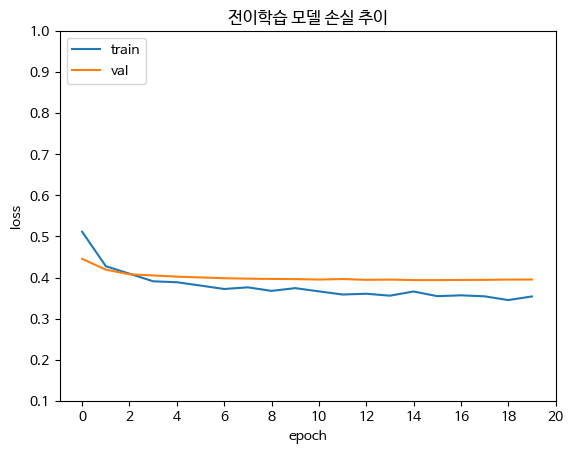

In [30]:
# transfer_learning_history 시각화

plt.plot(transfer_learning_history.history['loss'])
plt.plot(transfer_learning_history.history['val_loss'])
plt.title('전이학습 모델 손실 추이')
plt.xticks(range(0, 21, 2))
plt.ylim([0.1, 1.0])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

16/16 [==============================] - 4s 82ms/step


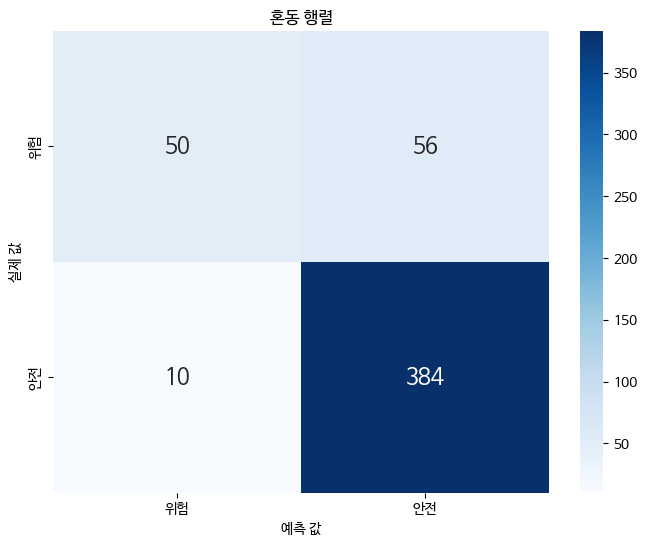

In [31]:
# 혼동 행렬 시각화

model = load_model('best_model.keras')
predicted_probabilities = model.predict(x_test)
threshold = 0.5
y_pred = (predicted_probabilities > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
            xticklabels=['위험', '안전'], yticklabels=['위험', '안전'])
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.title('혼동 행렬')
plt.show()

# Class 가중치 적용

In [32]:
# 레이블 데이터에서 안전하지 않은(unsafe) 샘플과 안전한(safe) 샘플의 수를 세어 bincount 함수로 계산합니다.
unsafe, safe = np.bincount(label_data)

# 전체 샘플 수를 계산합니다.
total = unsafe + safe

# 안전하지 않은 샘플에 적용할 가중치를 계산합니다. 적은 수의 샘플을 가진 클래스에 더 높은 가중치를 부여합니다.
weight_for_unsafe = (1 / unsafe) * (total / 2.0)

# 안전한 샘플에 적용할 가중치를 계산합니다.
weight_for_safe = (1 / safe) * (total / 2.0)

# 클래스 별 가중치를 딕셔너리로 저장합니다. 여기서 0은 '안전하지 않음', 1은 '안전함'을 나타냅니다.
class_weight = {0: weight_for_unsafe, 1: weight_for_safe}

# 계산된 각 클래스의 가중치를 출력합니다.
print('Weight for class 0: {:.2f}'.format(weight_for_unsafe))
print('Weight for class 1: {:.2f}'.format(weight_for_safe))

Weight for class 0: 2.36
Weight for class 1: 0.63


In [33]:
model = Sequential()
model.add(feature_extractor)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0005),
             loss='binary_crossentropy',
             metrics=['accuracy',
                      Recall(name='recall'),
                      Precision(name='precision'),
                      AUC(name='auc')])
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode='max', verbose=1)
transfer_learning_with_class_weight_history = model.fit(x_train, y_train, batch_size=32, validation_split=0.2, epochs=20, class_weight=class_weight, callbacks=[ model_checkpoint])

Epoch 1/20
112/113 [============================>.] - ETA: 0s - loss: 0.6576 - accuracy: 0.6069 - recall: 0.6077 - precision: 0.8503 - auc: 0.6587
Epoch 1: val_auc improved from -inf to 0.77941, saving model to best_model.keras
113/113 [==============================] - 25s 101ms/step - loss: 0.6564 - accuracy: 0.6072 - recall: 0.6080 - precision: 0.8510 - auc: 0.6595 - val_loss: 0.6065 - val_accuracy: 0.6878 - val_recall: 0.6700 - val_precision: 0.9100 - val_auc: 0.7794
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.5560 - accuracy: 0.7378 - recall: 0.7462 - precision: 0.9043 - auc: 0.7878
Epoch 2: val_auc improved from 0.77941 to 0.79592, saving model to best_model.keras
113/113 [==============================] - 9s 76ms/step - loss: 0.5560 - accuracy: 0.7378 - recall: 0.7462 - precision: 0.9043 - auc: 0.7878 - val_loss: 0.5512 - val_accuracy: 0.7478 - val_recall: 0.7645 - val_precision: 0.9003 - val_auc: 0.7959
Epoch 3/20
113/113 [===========================

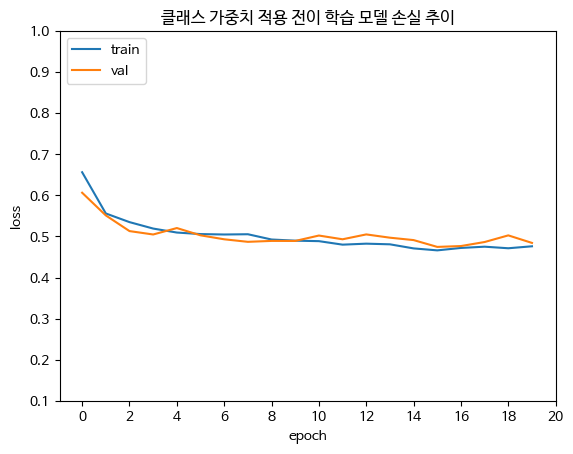

In [34]:
# transfer_learning_with_class_weight_history 시각화

plt.plot(transfer_learning_with_class_weight_history.history['loss'])
plt.plot(transfer_learning_with_class_weight_history.history['val_loss'])
plt.title('클래스 가중치 적용 전이 학습 모델 손실 추이')
plt.xticks(range(0, 21, 2))
plt.ylim([0.1, 1.0])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

16/16 [==============================] - 3s 40ms/step


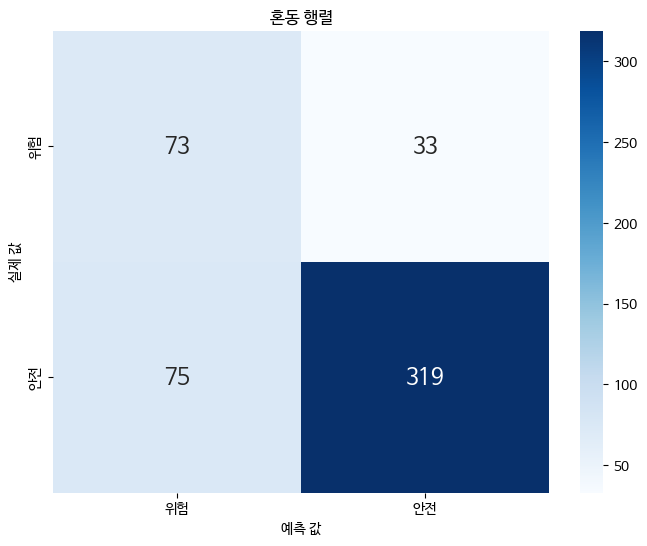

In [35]:
# 혼동 행렬 시각화

model = load_model('best_model.keras')
predicted_probabilities = model.predict(x_test)
threshold = 0.5
y_pred = (predicted_probabilities > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
            xticklabels=['위험', '안전'], yticklabels=['위험', '안전'])
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.title('혼동 행렬')
plt.show()